# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

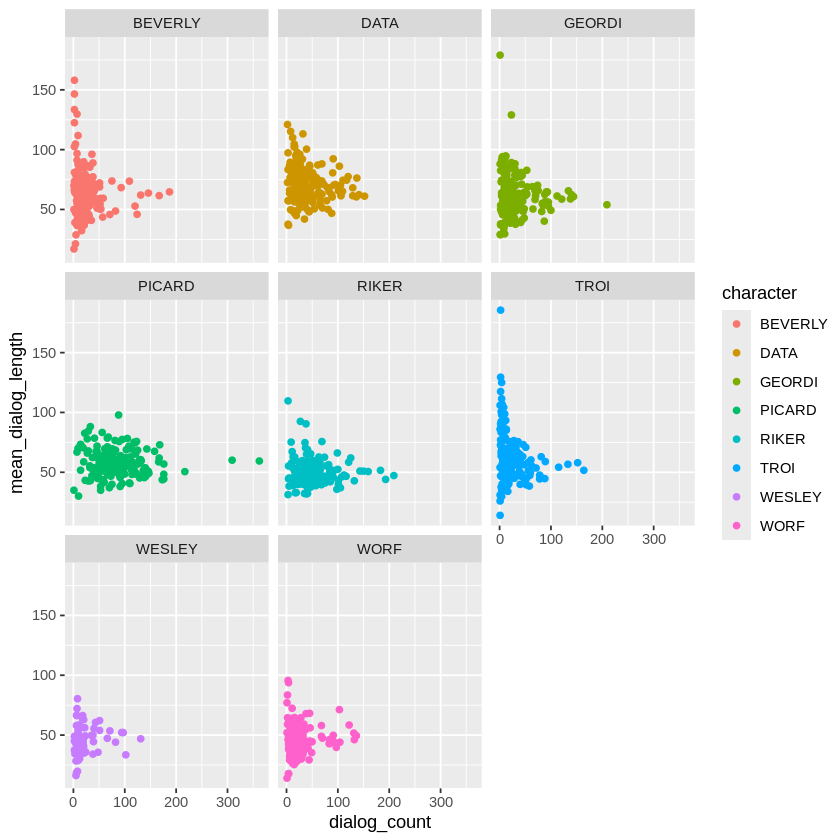

In [2]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) +
    geom_point(aes(color=character)) +
    facet_wrap(~character)

We can learn a bit about a character's role from the plots by seeing which characters have low dialogue counts but high dialogue lengths. Characters with dots in these areas probably have important information to share either at the beginning or end of the episode, but rarely speak inbetween. characters with both medium to high levels of both are probably main characters. Characters with high dialog counts and lower mean dialogue length are likely to be the main characters of those respective episodes.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`.
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season.

In [3]:
beverly_dialog <- dialogs_fixed %>%
  filter(character == "BEVERLY", episode_number >= 102 & episode_number <= 174) %>%
  mutate(season = case_when(
    episode_number >= 102 & episode_number <= 126 ~ "Season 1",
    episode_number >= 149 & episode_number <= 174 ~ "Season 3",
    TRUE ~ "Other"
  )) %>%
  filter(season != "Other") %>%
  group_by(season, episode_number) %>%
  summarize(mean_dialog_length = mean(dialog_length), dialog_count = n(), .groups = "drop") %>%
  group_by(season) %>%
  summarize(mean_mean_dialog_length = mean(mean_dialog_length), mean_dialog_count = mean(dialog_count))

beverly_dialogs

season,mean_mean_dialog_length,mean_dialog_count
<chr>,<dbl>,<dbl>
Season 1,56.48460,25.40
Season 3,67.04817,19.64


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

This is reflected in our table as we can see that although she has less dialog on average, in the moments she did talk, she was talking for longer periods of time.

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character.
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [6]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [7]:
tokens <- dialogs_fixed %>%
  # Split each dialog into words
  mutate(word_list = str_split(dialog, "\\s+")) %>%

  # Unnest the list column so each word is a row
  unnest(word_list) %>%

  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%

  # Remove empty strings and stopwords
  filter(word != "", !word %in% stop_words)

head(tokens)

episode_number,character,dialog,dialog_length,word_list,word
<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Captain's,captains
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"log,",log
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,stardate,stardate
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,42353.7.,423537
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,destination,destination
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,planet,planet


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [8]:
vocabulary_richness <- tokens %>%
  group_by(character) %>%
  summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocabulary_richness = unique_words / total_words
  ) %>%
  arrange(desc(vocabulary_richness))

print(vocabulary_richness)

# A tibble: 8 × 4
  character total_words unique_words vocabulary_richness
  <chr>           <int>        <int>               <dbl>
1 WESLEY           7601         2291               0.301
2 WORF            18820         4318               0.229
3 TROI            19450         4187               0.215
4 BEVERLY         22900         4875               0.213
5 DATA            45462         8593               0.189
6 GEORDI          31978         5465               0.171
7 RIKER           41827         6458               0.154
8 PICARD          79214         9272               0.117


#### c) Plot total words versus vocab richness.
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

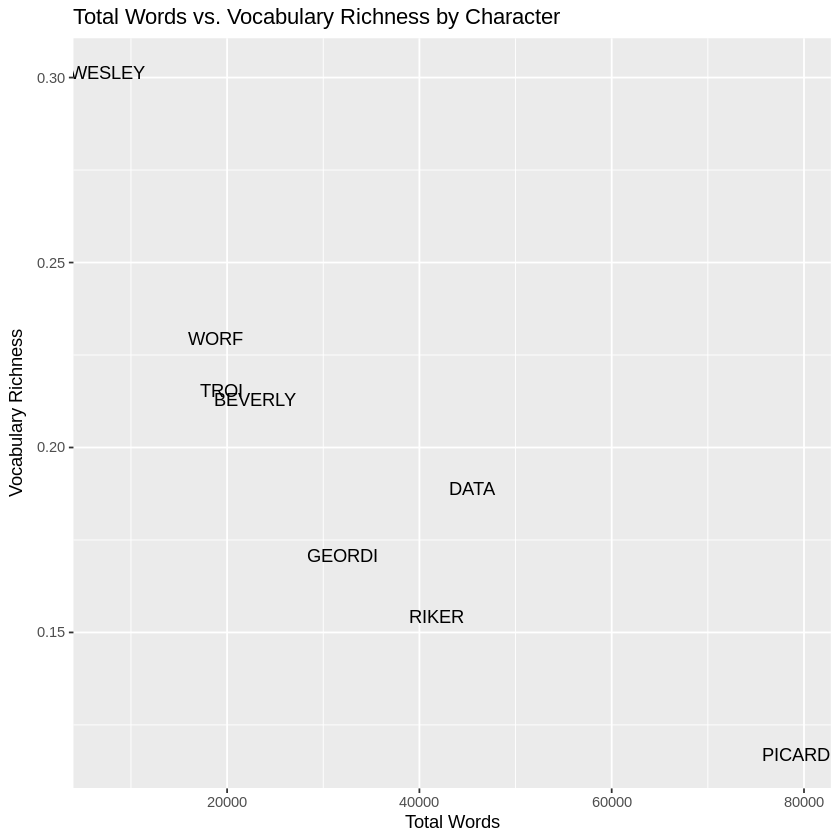

In [9]:
ggplot(vocabulary_richness, aes(x = total_words, y = vocabulary_richness)) +
  geom_text(aes(label = character)) +
  labs(
    title = "Total Words vs. Vocabulary Richness by Character",
    x = "Total Words",
    y = "Vocabulary Richness"
  ) +
  theme(legend.position = "none")

#### d) Interpret these results.

Characters such as Wesley do not speak much but have a rather high vocabulary richness, while Picard would be considered a main character but they do not have too high of a richness due to the vast amount of speaking he does compared to others.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row.
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap.

In [10]:
wesley_dialog_after_s3 <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number > 174) %>%
  group_by(episode_number) %>%
  summarize(dialog_count = n(), .groups = "drop")

print(wesley_dialog_after_s3)

# Wesley left the main cast after episode 183, as there is a significant gap between episodes where he speaks

# A tibble: 11 × 2
   episode_number dialog_count
            <dbl>        <int>
 1            175           18
 2            176            6
 3            177            9
 4            178            6
 5            179           38
 6            181            2
 7            183           94
 8            206          131
 9            219           71
10            263           18
11            272           97


#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

It appears as if Wesley makes guest appearances within episode 206, 219, 263, and 272.

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [15]:
# Wesley's last dialog before he left the main cast
wesley_last_dialog_main_cast <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number <= 183) %>%
  slice_tail(n = 1)

print("Wesley's last piece of dialog before he left the main cast:")
print(wesley_last_dialog_main_cast$dialog)

# Wesley's last dialog ever
wesley_last_dialog_ever <- dialogs_fixed %>%
  filter(character == "WESLEY") %>%
  slice_tail(n = 1)

print("Wesley's last piece of dialog ever:")
print(wesley_last_dialog_ever$dialog)

[1] "Wesley's last piece of dialog before he left the main cast:"
[1] "I can walk."
[1] "Wesley's last piece of dialog ever:"
[1] "Good-bye, Mom."


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title.
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

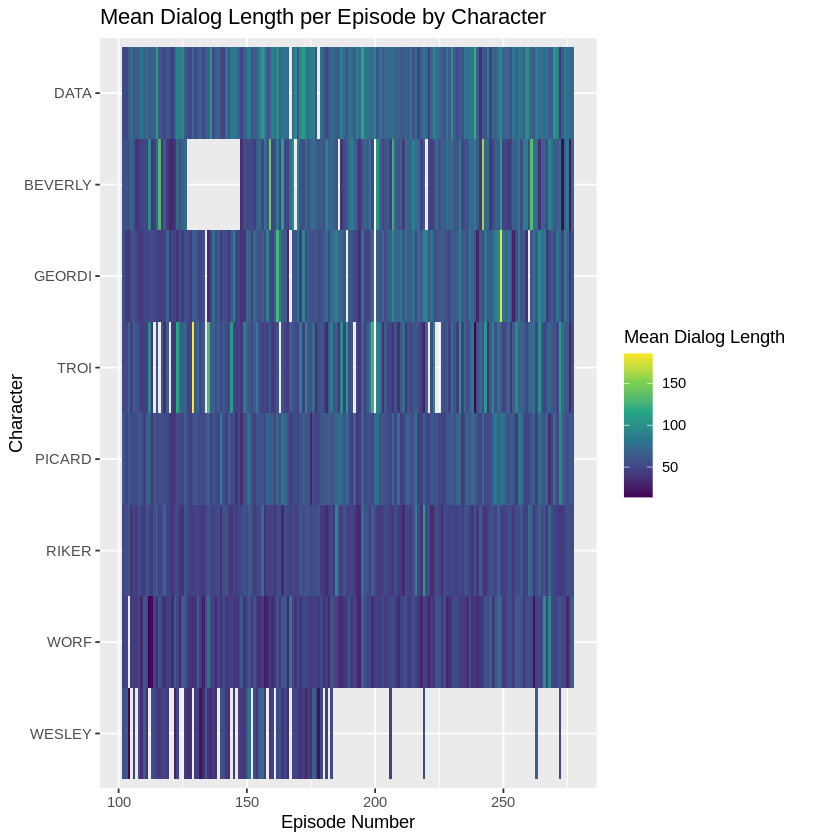

In [13]:
# overall mean (mean of mean) dialog length per character
overall_mean_dialog_length <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(overall_mean = mean(mean_dialog_length)) %>%
  arrange(overall_mean) %>%
  pull(character)

# convert character to factor
dialog_len_per_ep <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = overall_mean_dialog_length))

# heatmap
ggplot(dialog_len_per_ep, aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile() +
  labs(
    title = "Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character",
    fill = "Mean Dialog Length"
  ) +
  scale_fill_viridis_c()